In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
# install xgboost if you need it (uncomment to run)
# !pip install xgboost
# from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, precision_score, recall_score, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and display the dataset
df = pd.read_csv('Airline_Delay_Cause.csv')
df.head()

,year,month,carrier,carrier_name,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,8,9E,Endeavor Air Inc.,ABE,89.0,13.0,2.25,1.60,3.16,0.0,5.99,2.0,1.0,1375.0,71.0,761.0,118.0,0.0,425.0
1,2023,8,9E,Endeavor Air Inc.,ABY,62.0,10.0,1.97,0.04,0.57,0.0,7.42,0.0,1.0,799.0,218.0,1.0,62.0,0.0,518.0
2,2023,8,9E,Endeavor Air Inc.,AEX,62.0,10.0,2.73,1.18,1.80,0.0,4.28,1.0,0.0,766.0,56.0,188.0,78.0,0.0,444.0
3,2023,8,9E,Endeavor Air Inc.,AGS,66.0,12.0,3.69,2.27,4.47,0.0,1.57,1.0,1.0,1397.0,471.0,320.0,388.0,0.0,218.0
4,2023,8,9E,Endeavor Air Inc.,ALB,92.0,22.0,7.76,0.00,2.96,0.0,11.28,2.0,0.0,1530.0,628.0,0.0,134.0,0.0,768.0


In [3]:
# Drop rows with missing key columns needed for target/label creation
df = df.dropna(subset=["arr_delay", "arr_flights", "arr_del15"]).reset_index(drop=True)

# Remove rows where arr_flights is zero to avoid division by zero
df = df[df["arr_flights"] > 0].reset_index(drop=True)

# Create delay_rate feature (fraction of flights delayed >=15 minutes)
df["delay_rate"] = df["arr_del15"] / df["arr_flights"]

print("Dataset shape after cleaning:", df.shape)
print(df.head())

# One-hot encode categorical and object features
cat_cols = df.select_dtypes(include=["object", "category"]).columns
print("\nCategorical columns:", list(cat_cols))

df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df_encoded.head()

# Create target variables 
X_reg = df_encoded.drop("arr_delay", axis=1)
y_reg = df_encoded["arr_delay"]

# Classification target: high vs low delay_rate
delay_rate_threshold = 0.25   # 25% of flights delayed >= 15 minutes
df_encoded["High_Delay"] = (df["delay_rate"] > delay_rate_threshold).astype(int)

X_cls = df_encoded.drop("High_Delay", axis=1)
y_cls = df_encoded["High_Delay"]

Dataset shape after cleaning: (171223, 21)
   year  month carrier       carrier_name airport  arr_flights  arr_del15  \
0  2023      8      9E  Endeavor Air Inc.     ABE         89.0       13.0   
1  2023      8      9E  Endeavor Air Inc.     ABY         62.0       10.0   
2  2023      8      9E  Endeavor Air Inc.     AEX         62.0       10.0   
3  2023      8      9E  Endeavor Air Inc.     AGS         66.0       12.0   
4  2023      8      9E  Endeavor Air Inc.     ALB         92.0       22.0   

   carrier_ct  weather_ct  nas_ct  ...  late_aircraft_ct  arr_cancelled  \
0        2.25        1.60    3.16  ...              5.99            2.0   
1        1.97        0.04    0.57  ...              7.42            0.0   
2        2.73        1.18    1.80  ...              4.28            1.0   
3        3.69        2.27    4.47  ...              1.57            1.0   
4        7.76        0.00    2.96  ...             11.28            2.0   

   arr_diverted  arr_delay  carrier_delay  

In [4]:
# Classification: train Decision Tree to predict High_Delay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
# Prepare features and target (created earlier)
X = X_cls.copy()
y = y_cls.copy()
print('Features shape:', X.shape)
print('Target distribution:\n', y.value_counts(normalize=True))

Features shape: (171223, 450)
Target distribution:
 High_Delay
0    0.778856
1    0.221144
Name: proportion, dtype: float64


In [5]:
# Train/test split (stratify because class imbalance likely)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Grid search for best Decision Tree
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt = DecisionTreeClassifier(random_state=42)
scoring_metric = 'f1' if len(np.unique(y))==2 else 'accuracy'
cv = GridSearchCV(dt, param_grid, scoring=scoring_metric, cv=5, n_jobs=-1)
cv.fit(X_train_scaled, y_train)
best_dt = cv.best_estimator_
print('Best params:', cv.best_params_)

Best params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


Accuracy: 1.0

Classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26672
           1       1.00      1.00      1.00      7573

    accuracy                           1.00     34245
   macro avg       1.00      1.00      1.00     34245
weighted avg       1.00      1.00      1.00     34245

Confusion matrix:
 [[26672     0]
 [    0  7573]]


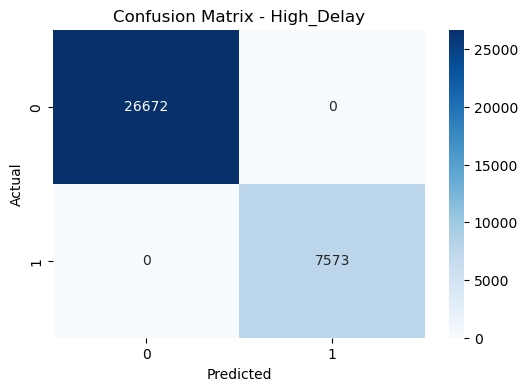

In [7]:
# Evaluate on test set
y_pred = best_dt.predict(X_test_scaled)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification report:\n')
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', cm)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - High_Delay')
plt.show()

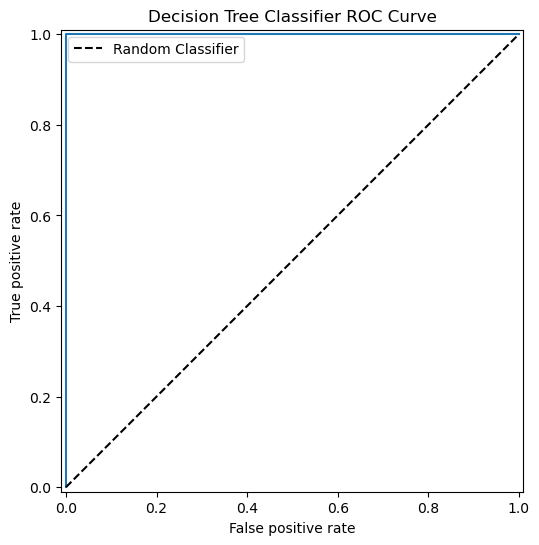

In [10]:
from sklearn.metrics import RocCurveDisplay, roc_curve 
import matplotlib.pyplot as plt

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, best_dt.predict_proba(X_test_scaled)[:, 1])

fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax.set_title('Decision Tree Classifier ROC Curve')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.legend()
plt.show()


Top features:
 delay_rate     1.0
year           0.0
month          0.0
arr_flights    0.0
airport_SWF    0.0
airport_SWO    0.0
airport_SYR    0.0
airport_TBN    0.0
airport_TLH    0.0
airport_TOL    0.0
airport_TPA    0.0
airport_TRI    0.0
airport_TTN    0.0
airport_TUL    0.0
airport_TUS    0.0
airport_TVC    0.0
airport_TWF    0.0
airport_TXK    0.0
carrier_AA     0.0
carrier_AS     0.0
dtype: float64


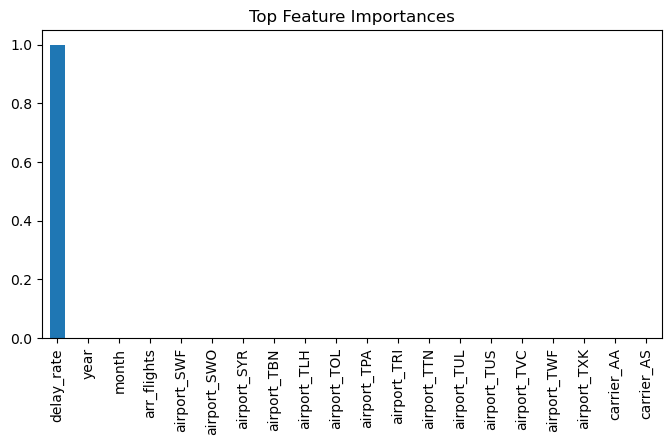

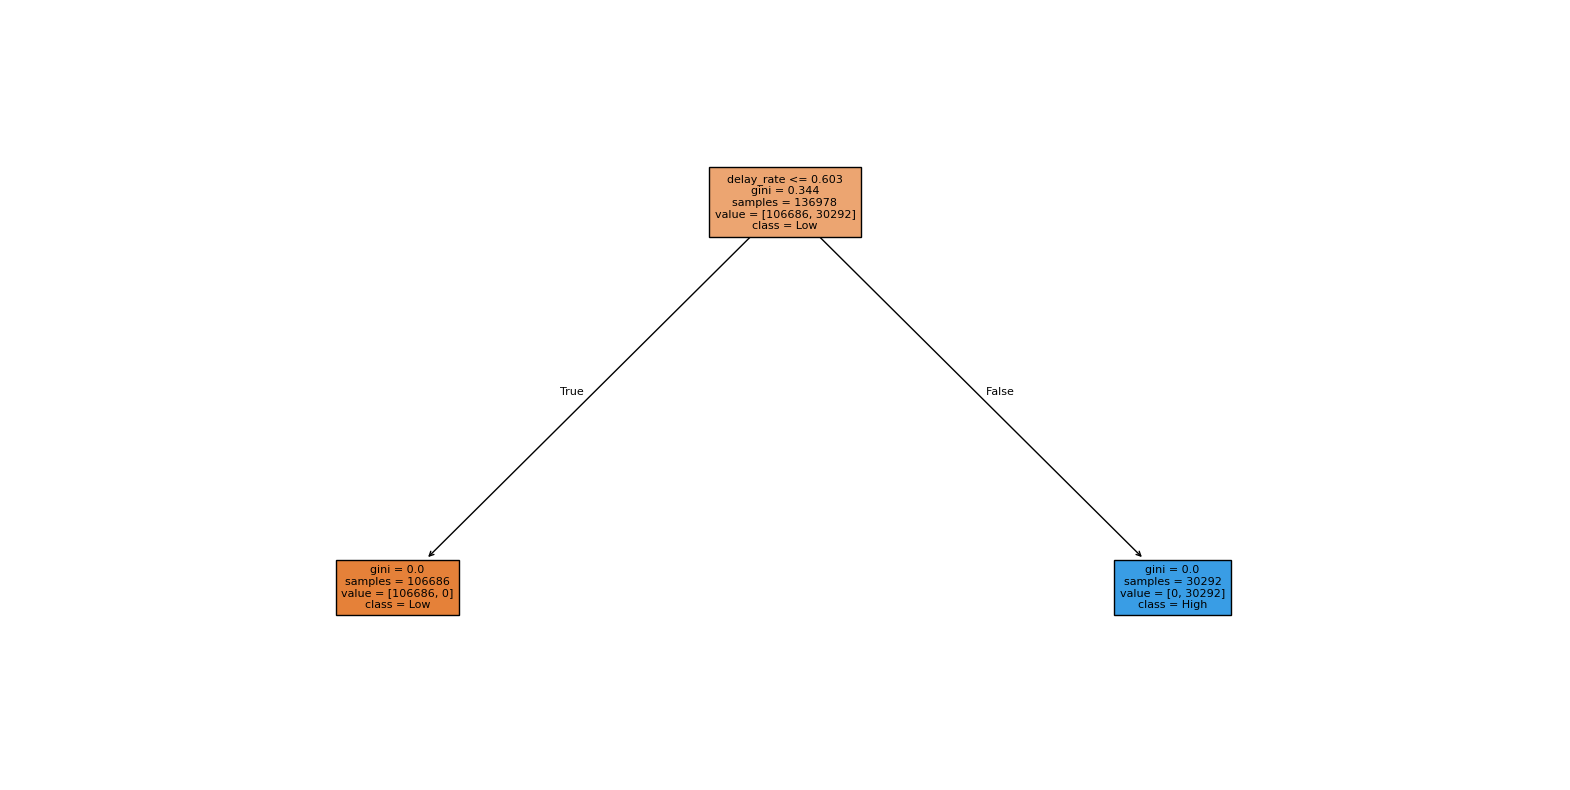

['scaler_high_delay.joblib']

In [11]:

# Feature importances
if hasattr(best_dt, 'feature_importances_'):
    fi = pd.Series(best_dt.feature_importances_, index=X.columns).sort_values(ascending=False).head(20)
    print('\nTop features:\n', fi)
    plt.figure(figsize=(8,4))
    fi.plot(kind='bar')
    plt.title('Top Feature Importances')
    plt.show()
# Visualize top levels of the tree
plt.figure(figsize=(20,10))
plot_tree(best_dt, feature_names=X.columns, class_names=['Low','High'], filled=True, max_depth=3, fontsize=8)
plt.show()
# Persist model and scaler
joblib.dump(best_dt, 'decision_tree_high_delay.joblib')
joblib.dump(scaler, 'scaler_high_delay.joblib')